<a href="https://colab.research.google.com/github/prj-07/FlowerClassification/blob/main/JovianProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 1.7 MB/s 


### DOWNLOAD THE DATASET(USE LIB OPENDATASETS)



In [ ]:
!pip install  opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [ ]:
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pratyushraj07
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:10<00:00, 21.6MB/s]


In [ ]:
data_dir = './flowers-recognition'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['flowers']

In [ ]:
data_dir_main = './flowers-recognition/flowers'

In [ ]:
os.listdir(data_dir_main)

['daisy', 'tulip', 'dandelion', 'rose', 'sunflower']

In [ ]:
import shutil

In [ ]:
#shutil.rmtree('./rice-image-dataset ')

In [ ]:
import torch 

In [ ]:
import torchvision

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
data = ImageFolder(data_dir_main) ##picks out images from folders

In [ ]:
len(data)

4317

In [ ]:
data[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F7E25440E50>, 0)

In [ ]:
data.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
#for cls in os.listdir(data_dir_main):
 # print(cls,':',len( os.listdir(data_dir_main +'/'+cls)))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

0


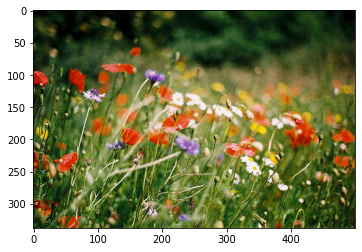

In [ ]:
img,label = data[500]
plt.imshow(img)
print(label)

In [ ]:
import torchvision.transforms as tt

In [ ]:
data  = ImageFolder(data_dir_main,tt.Compose([tt.Resize(32),tt.RandomCrop(32),tt.ToTensor()]))

0


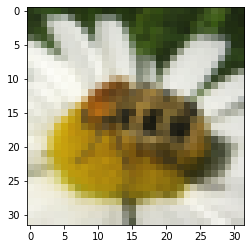

In [ ]:
img,label = data[120]
plt.imshow(img.permute(1,2,0))
print(label)


In [ ]:
from torch.utils.data import random_split

In [ ]:
val_pct = .1
val_size = int(val_pct* len(data))
train_size = len(data) - val_size


In [ ]:
val_size,train_size

(431, 3886)

In [ ]:
train_ds,val_ds = random_split(data,[train_size,val_size])

###CREATE DATALOADERS

In [ ]:
batch_size = 50

In [ ]:
from torch.utils.data.dataloader import DataLoader

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(60, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

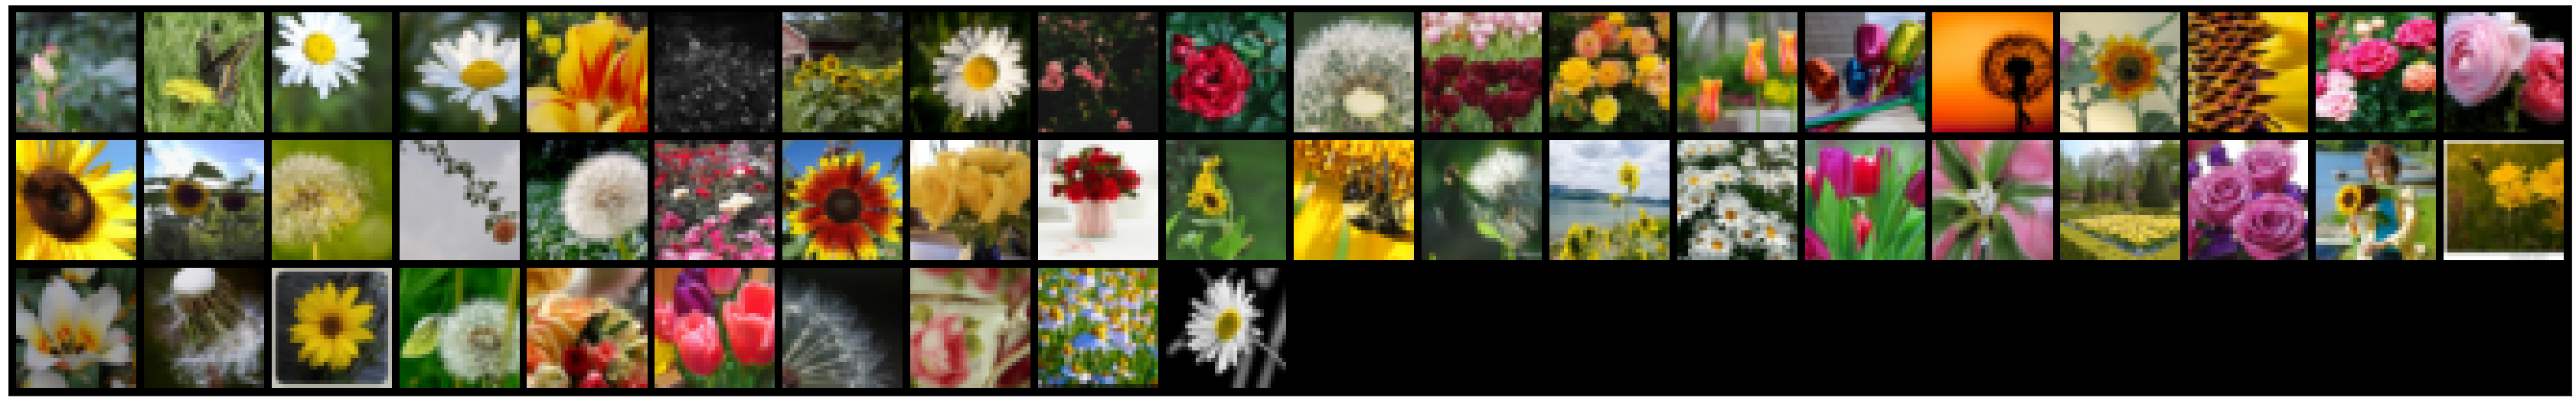

In [ ]:
show_batch(train_dl)

##GPU Utilities

```
# This is formatted as code
```

 for training

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img,label = data[0]

In [ ]:
img.shape

torch.Size([3, 32, 32])

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)

In [ ]:
val_dl = DeviceDataLoader(val_dl,device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

##Model training Utilities

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

##Model building (either from scratch or pre trained )

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [ ]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
torch.cuda.empty_cache()
model = to_device(ResNet9(3, len(data.classes)), device) ## 3 ---no of input channels rgb
model 

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
?nn.BatchNorm2d

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

##Pass one batch of input tenosr through Model

In [ ]:
for batch in train_dl:
  images,label = batch
  preds = model(images)
  print(preds)
  break

tensor([[ 0.2237,  0.1631,  1.3962,  1.5177, -1.3069],
        [-0.8949,  0.9261, -1.1546,  0.5347, -3.2536],
        [-1.6047,  3.1700, -1.2321,  0.0486, -2.4180],
        [ 0.6183,  1.2308,  0.0081, -0.9215, -2.0993],
        [-1.0452,  2.1356,  0.3791,  0.8310, -0.6984],
        [ 0.4449,  0.6148, -0.8428, -0.5014, -4.0296],
        [-0.4223,  0.7211, -0.2451, -0.9614, -0.8417],
        [-0.6494,  2.2087, -1.2391, -1.6155, -0.9858],
        [-0.9936,  0.4106,  0.6708,  0.9197, -1.8961],
        [-0.8943,  0.8118, -1.0455, -1.6157, -2.9210],
        [-0.5207,  2.0215, -0.8217, -0.1700, -2.3437],
        [-0.8405, -0.0715,  1.7788, -1.7855, -3.5657],
        [-0.9976,  1.5838,  1.2086, -0.1819, -2.2062],
        [-0.0471,  2.3378, -0.3151,  0.7195, -2.2808],
        [-1.5338,  1.3503,  0.8941, -0.5118, -2.5977],
        [-2.0224,  1.7456,  1.2949, -0.7717, -1.3859],
        [ 0.4237, -1.3851, -0.5929,  2.0490, -1.3385],
        [ 0.7319, -0.5941,  1.3665, -0.3951, -1.1861],
        [-

###Training

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.6087290048599243, 'val_acc': 0.2205161303281784}]

In [ ]:
history += fit(5,.1,model,train_dl,val_dl,torch.optim.Adam)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 6.2115, val_loss: 1.5633, val_acc: 0.2556
Epoch [1], train_loss: 1.5603, val_loss: 1.5307, val_acc: 0.2438
Epoch [2], train_loss: 1.5155, val_loss: 1.4966, val_acc: 0.3759
Epoch [3], train_loss: 1.4885, val_loss: 1.4601, val_acc: 0.3101
Epoch [4], train_loss: 1.4677, val_loss: 1.4380, val_acc: 0.3356


In [ ]:
history += fit(3,.05,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.4661, val_loss: 1.4730, val_acc: 0.3799
Epoch [1], train_loss: 1.4067, val_loss: 1.3661, val_acc: 0.3974
Epoch [2], train_loss: 1.2814, val_loss: 1.2030, val_acc: 0.5021


In [ ]:
history += fit(3,.01,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.2023, val_loss: 1.0922, val_acc: 0.5094
Epoch [1], train_loss: 1.1789, val_loss: 1.0826, val_acc: 0.5159
Epoch [2], train_loss: 1.1413, val_loss: 1.0563, val_acc: 0.5672


In [ ]:
history += fit(3,.01,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.1159, val_loss: 1.0461, val_acc: 0.6041
Epoch [1], train_loss: 1.1228, val_loss: 1.0146, val_acc: 0.5583
Epoch [2], train_loss: 1.0703, val_loss: 1.0223, val_acc: 0.5768


In [ ]:
history += fit(5,.008,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.0497, val_loss: 1.0319, val_acc: 0.5972
Epoch [1], train_loss: 1.0395, val_loss: 1.0357, val_acc: 0.5741
Epoch [2], train_loss: 1.0217, val_loss: 0.9521, val_acc: 0.6486
Epoch [3], train_loss: 0.9763, val_loss: 0.9359, val_acc: 0.6054
Epoch [4], train_loss: 0.9514, val_loss: 0.9168, val_acc: 0.6392


In [ ]:
history += fit(3,.005,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.9279, val_loss: 0.8973, val_acc: 0.6786
Epoch [1], train_loss: 0.9224, val_loss: 0.8897, val_acc: 0.6650
Epoch [2], train_loss: 0.8932, val_loss: 0.8814, val_acc: 0.6666


In [ ]:
history += fit(3,.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.8688, val_loss: 0.8615, val_acc: 0.6866
Epoch [1], train_loss: 0.8661, val_loss: 0.8628, val_acc: 0.6755
Epoch [2], train_loss: 0.8711, val_loss: 0.8580, val_acc: 0.6766


In [ ]:
history += fit(3,.0005,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.8569, val_loss: 0.8517, val_acc: 0.6886
Epoch [1], train_loss: 0.8524, val_loss: 0.8449, val_acc: 0.6890
Epoch [2], train_loss: 0.8342, val_loss: 0.8143, val_acc: 0.6995


In [ ]:
history += fit(3,.0005,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.8611, val_loss: 0.8354, val_acc: 0.7015
Epoch [1], train_loss: 0.8519, val_loss: 0.8692, val_acc: 0.6906
Epoch [2], train_loss: 0.8383, val_loss: 0.8362, val_acc: 0.6946


In [ ]:
history += fit(3,.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.8634, val_loss: 0.8574, val_acc: 0.6592
Epoch [1], train_loss: 0.8345, val_loss: 0.8411, val_acc: 0.6941
Epoch [2], train_loss: 0.8497, val_loss: 0.8134, val_acc: 0.7026


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

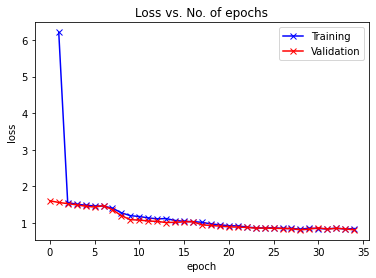

In [ ]:
plot_losses(history)

In [ ]:
history += fit(4,.0001,model,train_dl,val_dl,torch.optim.Adam)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.8205, val_loss: 0.8128, val_acc: 0.7155
Epoch [1], train_loss: 0.8317, val_loss: 0.8483, val_acc: 0.6866
Epoch [2], train_loss: 0.8162, val_loss: 0.8341, val_acc: 0.6950
Epoch [3], train_loss: 0.8386, val_loss: 0.7988, val_acc: 0.7095


In [ ]:
history += fit(3,.0001,model,train_dl,val_dl,)

Epoch [0], train_loss: 0.8178, val_loss: 0.8129, val_acc: 0.6986
Epoch [1], train_loss: 0.8249, val_loss: 0.8494, val_acc: 0.6786
Epoch [2], train_loss: 0.8361, val_loss: 0.8341, val_acc: 0.6970


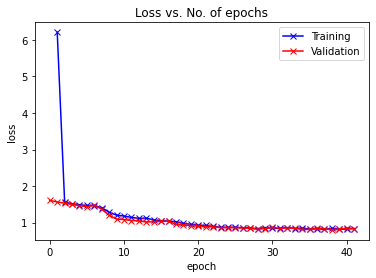

In [ ]:
plot_losses(history)

In [ ]:
import jovian

In [ ]:
jovian.commit(project ='first project ')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


##Testing with individual images

In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
img,label = val_ds[0]
predict_image(img,model,data.classes)

'rose'

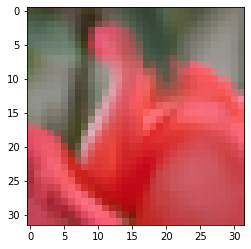

In [ ]:
plt.imshow(img.permute(1,2,0))

In [ ]:
img,label = val_ds[0]
#predict_image(img,model,data.classes)

ValueError: ignored

In [ ]:
def show_imagegpred(img,label) :
  predicted = predict_image(img,model,data.classes)
  print('original label:',data.classes[label])  
  print('predicted:', predicted)
  plt.imshow(img.permute(1,2,0))
  

original label: dandelion
predicted: dandelion


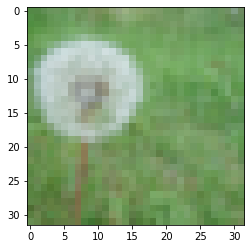

In [ ]:
img,label = val_ds[50]
show_imagegpred(img,label)

In [ ]:
##to pass a tuple to dataset wee use *val_ds

original label: daisy
predicted: daisy


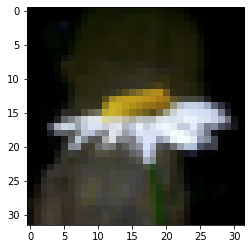

In [ ]:
show_imagegpred(*val_ds[16])

original label: tulip
predicted: dandelion


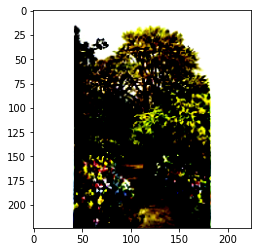

In [ ]:
show_imagegpred(*val_ds[6])

##Transfer Learning


In [ ]:
from torchvision import models

class Resnet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(Resnet34(len(data.classes),pretrained = True),device)

In [ ]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data  = ImageFolder(data_dir_main,tt.Compose([tt.Resize(img_size),tt.RandomCrop(img_size),tt.ToTensor(),tt.Normalize(*imagenet_stats)]))
train_ds,val_ds = random_split(data,[train_size,val_size])
batch_size = 50
from torch.utils.data.dataloader import DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(device)
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

cuda


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
history = evaluate(model,val_dl)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
history

{'val_loss': 1.7616361379623413, 'val_acc': 0.19980645179748535}

In [ ]:
history += fit_one_cycle(5,0.001,model,train_dl,val_dl,weight_decay = 0.01,grad_clip = 0.1,opt_func = torch.optim.Adam)

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.3978, val_loss: 5.0630, val_acc: 0.3121


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7372, val_loss: 1.6469, val_acc: 0.3699


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6565, val_loss: 0.8168, val_acc: 0.7273


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5240, val_loss: 0.5258, val_acc: 0.8082


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3578, val_loss: 0.4268, val_acc: 0.8562


TypeError: ignored

original label: daisy
predicted: daisy


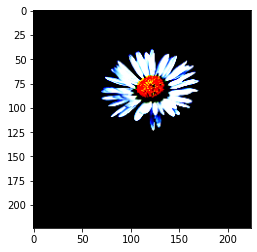

In [ ]:
img,label  = val_ds[10]
show_imagegpred(img,label)

In [ ]:
img,label = val_ds[12]

In [ ]:
img,label = val_ds[12]

In [ ]:
data.classes[label]

'dandelion'

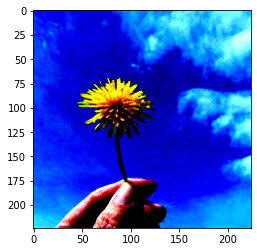

In [ ]:
plt.imshow(img.permute(1,2,0))